In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sirs_gillespie(
    beta0,   # mean transmission rate
    gamma,   # recovery rate
    mu,      # birth/death rate
    delta,   # waning immunity rate
    dbeta,   # seasonal amplitude of beta(t)
    S0, I0, R0,  # initial S,I,R
    T_max=520    # max time (weeks)
):
    """
    Compact Doob-Gillespie simulation for SIRS with seasonality and
    demographic (birth/death) stochasticity.
    
    Returns arrays of times and S,I,R values at each event.
    """
    
    # Initialize time and states
    t = 0.0
    S, I, R = S0, I0, R0
    
    # Lists for recording trajectory
    t_values = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]
    
    # We'll define the state-updates for each possible event:
    # (dS, dI, dR) in the same order as we compute the rates
    updates = [
        ( +1,  0,  0),  # Birth
        ( -1,  0,  0),  # Death of S
        (  0, -1,  0),  # Death of I
        (  0,  0, -1),  # Death of R
        ( -1, +1,  0),  # Infection S->I
        (  0, -1, +1),  # Recovery I->R
        ( +1,  0, -1)   # Waning R->S
    ]
    
    while t < T_max:
        N = S + I + R
        if N <= 0:  # population died out
            break
        
        # Seasonal transmission
        beta_t = beta0 * (1.0 + dbeta * np.sin(2.0*np.pi*t/52.0))
        
        # Calculate reaction rates
        birth_rate     = mu * N
        s_death_rate   = mu * S
        i_death_rate   = mu * I
        r_death_rate   = mu * R
        infection_rate = beta_t * S * I / N if N > 0 else 0.0
        recovery_rate  = gamma * I
        waning_rate    = delta * R
        
        rates = [
            birth_rate,
            s_death_rate,
            i_death_rate,
            r_death_rate,
            infection_rate,
            recovery_rate,
            waning_rate
        ]
        
        total_rate = sum(rates)
        if total_rate <= 0:
            break
        
        # Time to next event
        r1 = np.random.random()
        dt = -np.log(r1) / total_rate
        t_new = t + dt
        if t_new > T_max:
            # If next event is beyond T_max, stop
            break
        
        t = t_new
        
        # Determine which event occurs
        r2 = np.random.random() * total_rate
        cumulative = 0.0
        event_idx = None
        for i, rate in enumerate(rates):
            cumulative += rate
            if r2 < cumulative:
                event_idx = i
                break
        
        # Apply that event
        dS, dI, dR = updates[event_idx]
        S += dS
        I += dI
        R += dR

        # Avoid complete dying-out:
        I = max(1,I)
        
        # Record new state
        if t-t_values[-1] > 1/7: # Avoid excessive point density
            t_values.append(t)
            S_values.append(S)
            I_values.append(I)
            R_values.append(R)
            if int(t_values[-1]/52) > int(t_values[-2]/52):
                print("t/52:", t/52)
            
    
    return (
        np.array(t_values),
        np.array(S_values),
        np.array(I_values),
        np.array(R_values)
    )



In [9]:

beta0  = 0.713929532
gamma  = 1/2.5
mu     = 1/(80*52)
delta  = 0.0017271
dbeta  = 0.18569449

# Initial population

#np.random.seed(2)
#N0 = int(2e4)

#np.random.seed(4)
#N0 = int(2.5e5)

np.random.seed(2)
N0 = int(2e6)

I0 = int(0.005*N0)
R0 = int(0.35*N0)
S0 = N0 - I0 - R0

T_max = 150*52  # weeks

# Run simulation
t_vals, S_vals, I_vals, R_vals = sirs_gillespie(
    beta0, gamma, mu, delta, dbeta,
    S0, I0, R0,
    T_max
)

t/52: 1.000546016308069
t/52: 2.002658011839969
t/52: 3.002423457635516
t/52: 4.002628395610933
t/52: 5.002564492248752
t/52: 6.00253076412742
t/52: 7.000609478062319
t/52: 8.001337189296004
t/52: 9.00055926542949
t/52: 10.000381689487138
t/52: 11.000031766468881
t/52: 12.001812613927488
t/52: 13.002607644200557
t/52: 14.001037579311035
t/52: 15.000165010556174
t/52: 16.002080085162227
t/52: 17.001060588488585
t/52: 18.001958489219593
t/52: 19.000134839001745
t/52: 20.00170059404848
t/52: 21.000706820818703
t/52: 22.002305685200334
t/52: 23.00062417568794
t/52: 24.00172246047174
t/52: 25.000342833395777
t/52: 26.001792026945317
t/52: 27.000411827109822
t/52: 28.00149782145549
t/52: 29.00260193417342
t/52: 30.00125337617844
t/52: 31.002503539215613
t/52: 32.00092675585288
t/52: 33.0021733028011
t/52: 34.000662823618526
t/52: 35.00193017529516
t/52: 36.00037029418834
t/52: 37.00150466142689
t/52: 38.002702187548145
t/52: 39.00119137410579
t/52: 40.00253368035333
t/52: 41.00101375848898
t

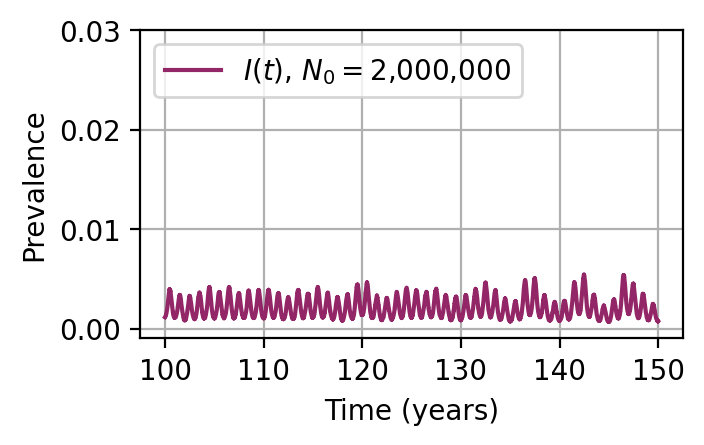

In [10]:
# Plot


plt.figure(figsize=(3.5,2), dpi=200)
t_plot = np.array(t_vals)/52
I_plot = np.array(I_vals)/N0

plot_mask = t_plot > 100
t_plot = t_plot[plot_mask]
I_plot = I_plot[plot_mask]

#plt.plot(t_vals, S_vals/N0, label='S', color='blue')
#plt.plot(np.array(t_vals)[-10000000:]/52, np.array(I_vals)[-10000000:]/N0, label='', color='red')
plt.plot(t_plot, I_plot, label=r'$I(t)$, ' + r"$N_0=$" + f'{N0:,}', color=plt.cm.inferno(0.4))
#plt.plot(t_vals, R_vals/N0, label='R', color='green')
plt.xlabel('Time (years)')
plt.ylabel('Prevalence')
#plt.title(f'Seasonal SIRS (Gillespie, ' + r"$N_0=$" + f'{N0:,})')
plt.legend(loc='upper left')
plt.grid()
plt.ylim([-0.001, 0.03])
plt.show()
